# Inneklima-analyse — BEMIFY Simuleringsresultater

Analyserer inneklimadata fra BEMIFY batch-simuleringer (JSON og NDJSON-format).

## 1. Last data

In [38]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['figure.dpi'] = 100

TIMESTEP_H = 0.25
STEPS_PER_YEAR = 35_040

# Tidsindeks: 15-min intervaller fra 1. jan
time_index = pd.date_range('2025-01-01', periods=STEPS_PER_YEAR, freq='15min')

In [39]:
# Last JSON-fil
RESULTS_DATA_PATH = Path('results_ny.json')

# Støtter tre format:
#   1. GUI-format: JSON-array med sone-objekter [{"id":..., "stepResults":...}, ...]
#   2. CLI-format: JSON-objekt med stepResultsPerSone {"stepResultsPerSone": {...}}
#   3. NDJSON: Én linje per simulering
entries = []
with open(RESULTS_DATA_PATH, 'r', encoding='utf-8') as f:
    content = f.read().strip()

data = json.loads(content) if content.startswith(('[', '{')) else None

if isinstance(data, list):
    # GUI-format: array av sone-objekter -> konverter til stepResultsPerSone
    step_results_per_sone = {zone['id']: zone['stepResults'] for zone in data}
    entries.append({
        'climateName': RESULTS_DATA_PATH.stem,
        'result': {'stepResultsPerSone': step_results_per_sone}
    })
elif isinstance(data, dict):
    if 'stepResultsPerSone' in data:
        entries.append({'climateName': RESULTS_DATA_PATH.stem, 'result': data})
    elif 'result' in data:
        entries.append(data)
    elif 'results' in data:
        entries.extend(data['results'])
else:
    # NDJSON
    for line in content.split('\n'):
        if line.strip():
            entries.append(json.loads(line))

print(f'Lastet {len(entries)} simulering(er)')
for e in entries:
    zones = list(e['result']['stepResultsPerSone'].keys())
    print(f"  {e['climateName']}: {len(zones)} sone(r)")

Lastet 1 simulering(er)
  results_ny: 1 sone(r)


In [40]:
# Velg simulering og bygg DataFrames per sone
SIM_INDEX = 0  # <-- Endre for å velge annen simulering

entry = entries[SIM_INDEX]
climate_name = entry['climateName']
step_results = entry['result']['stepResultsPerSone']
zone_ids = list(step_results.keys())

# Ekstraher inneklima til DataFrame per sone
inneklima_per_sone = {}

for zone_id in zone_ids:
    steps = step_results[zone_id]
    rows = []
    for step in steps:
        ik = step['inneklima']
        rows.append({
            'T_luft': ik['luftTemperatur'],
            'T_overflate': ik['overflateTemperatur'],
            'T_masse': ik['masseTemperatur'],
            'T_operativ': ik['operativTemperatur'],
            'T_tilluft': ik['tilluftsTemperatur'],
            'V_tilluft': ik['tilluftsLuftmengde'],
            'CO2': ik['CO2_nivå'],
            'RH': ik['relativ_fuktighet'],
        })
    df = pd.DataFrame(rows, index=time_index)
    inneklima_per_sone[zone_id] = df

print(f'Klimasted: {climate_name}')
print(f'Soner: {len(zone_ids)}')
for zid, df in inneklima_per_sone.items():
    print(f'  {zid}: {len(df)} tidssteg')
    print(f'    T_operativ: {df["T_operativ"].min():.1f} – {df["T_operativ"].max():.1f} °C')
    print(f'    CO2:        {df["CO2"].min():.0f} – {df["CO2"].max():.0f} ppm')

Klimasted: results_ny
Soner: 1
  soneE6JETHtWgwHndLJNEJOc1: 35040 tidssteg
    T_operativ: 20.8 – 23.6 °C
    CO2:        420 – 702 ppm


## 2. Temperaturer

In [41]:
# Tabell med verdier mellom start og slutt steg
start_step = 0  # Endre etter behov
end_step = 100  # Endre etter behov

for zone_id, df in inneklima_per_sone.items():
    if end_step > len(df):
        end_step = len(df)
    
    df_selection = df.iloc[start_step:end_step].copy()
    
    # Velg relevante kolonner for tabellen
    table_cols = ['T_luft', 'T_operativ', 'CO2', 'RH']
    available_cols = [col for col in table_cols if col in df_selection.columns]
    
    if available_cols:
        print(f'\nTabell for {zone_id} — Steg {start_step} til {end_step}:')
        print('=' * 80)
        # Vis alle rader eksplisitt
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', None)
        print(df_selection[available_cols].round(2).to_string())
        # Tilbakestill display-innstillinger
        pd.reset_option('display.max_rows')
        pd.reset_option('display.max_columns')
        pd.reset_option('display.width')
        pd.reset_option('display.max_colwidth')


Tabell for soneE6JETHtWgwHndLJNEJOc1 — Steg 0 til 100:
                     T_luft  T_operativ     CO2     RH
2025-01-01 00:00:00    21.7       21.58  647.80  44.75
2025-01-01 00:15:00    21.7       21.56  605.55  40.50
2025-01-01 00:30:00    21.7       21.54  571.35  37.04
2025-01-01 00:45:00    21.7       21.52  543.67  34.25
2025-01-01 01:00:00    21.7       21.51  521.26  31.77
2025-01-01 01:15:00    21.7       21.49  503.13  29.76
2025-01-01 01:30:00    21.7       21.47  488.45  28.13
2025-01-01 01:45:00    21.7       21.46  476.57  26.81
2025-01-01 02:00:00    21.7       21.44  466.95  25.54
2025-01-01 02:15:00    21.7       21.43  459.16  24.51
2025-01-01 02:30:00    21.7       21.41  452.86  23.67
2025-01-01 02:45:00    21.7       21.40  447.76  23.00
2025-01-01 03:00:00    21.7       21.39  443.63  22.25
2025-01-01 03:15:00    21.7       21.38  440.29  21.65
2025-01-01 03:30:00    21.7       21.36  437.59  21.16
2025-01-01 03:45:00    21.7       21.35  435.40  20.77
2025-01-0

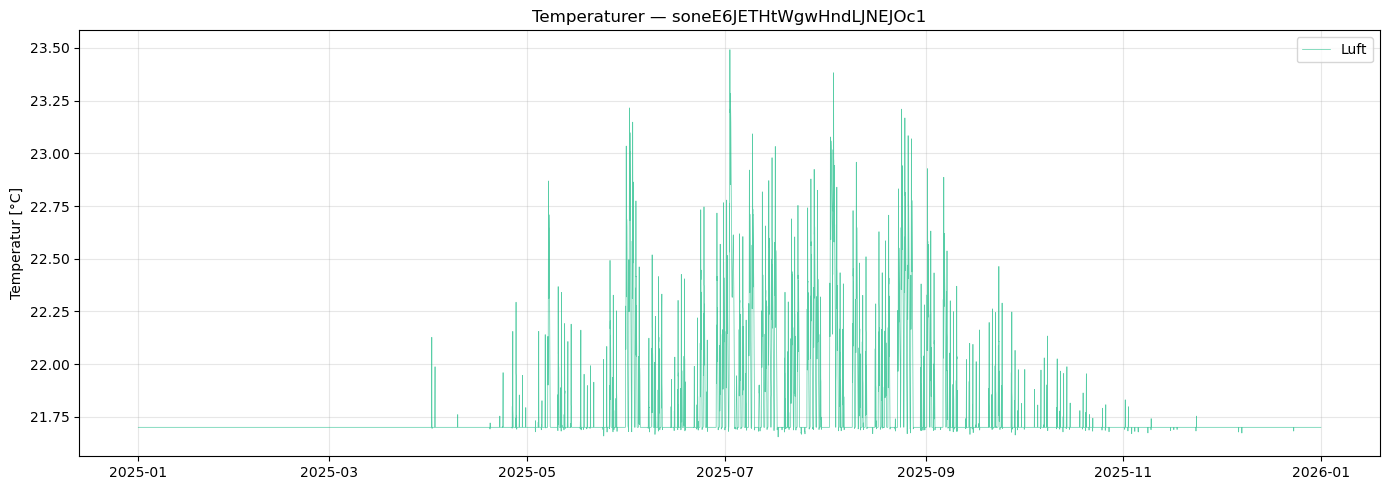

In [42]:
for zone_id, df in inneklima_per_sone.items():
    fig, ax = plt.subplots()
    
    # Resample til timesverdier for lesbarhet
    df_h = df.resample('h').mean()
    
    ax.plot(df_h.index, df_h['T_luft'], linewidth=0.5, label='Luft', color='#10b981', alpha=0.7)
    
    ax.set_ylabel('Temperatur [°C]')
    ax.set_title(f'Temperaturer — {zone_id}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    plt.show()

## 3. CO₂

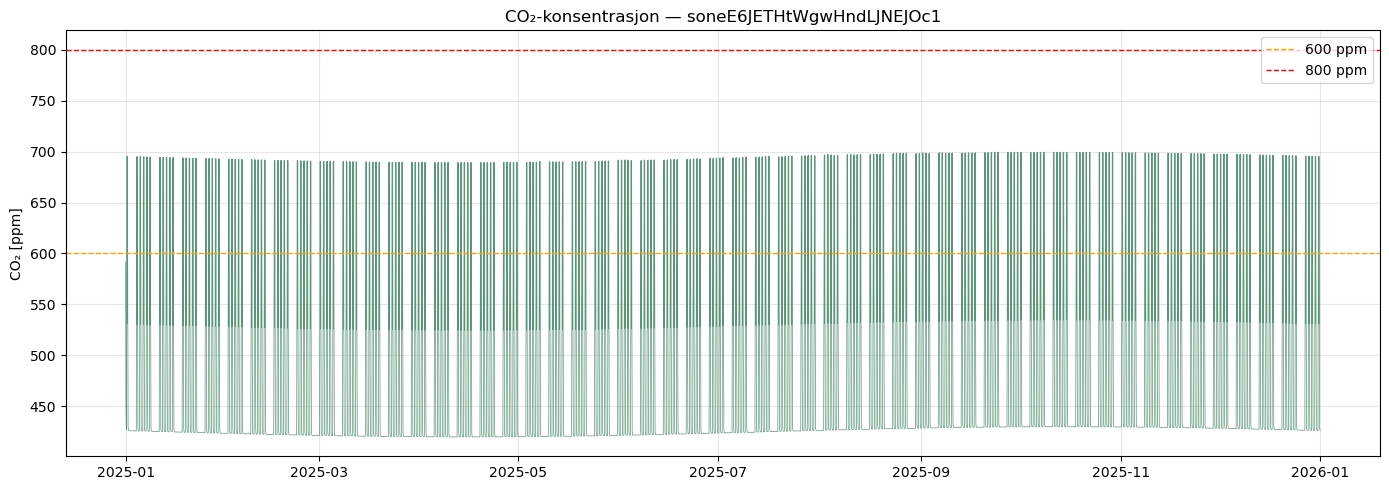

In [43]:
for zone_id, df in inneklima_per_sone.items():
    fig, ax = plt.subplots()
    df_h = df.resample('h').mean()
    
    ax.plot(df_h.index, df_h['CO2'], linewidth=0.5, color='#5b9679')
    ax.axhline(y=600, color='orange', linestyle='--', linewidth=1, label='600 ppm')
    ax.axhline(y=800, color='red', linestyle='--', linewidth=1, label='800 ppm')
    
    ax.set_ylabel('CO₂ [ppm]')
    ax.set_title(f'CO₂-konsentrasjon — {zone_id}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    plt.show()

## 4. Relativ fuktighet

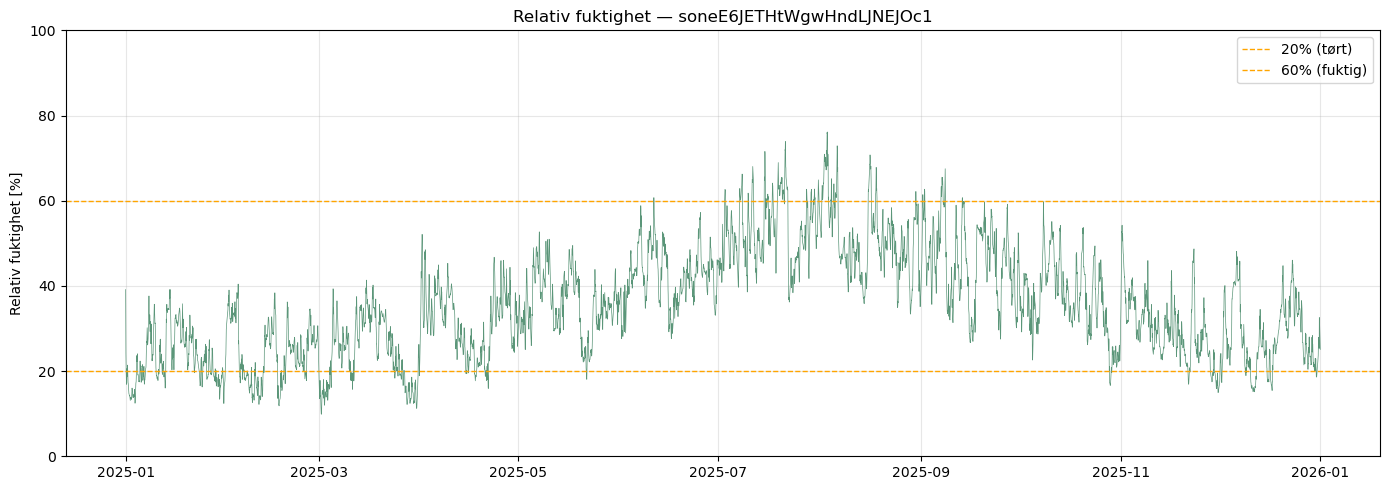

In [44]:
for zone_id, df in inneklima_per_sone.items():
    fig, ax = plt.subplots()
    df_h = df.resample('h').mean()
    
    ax.plot(df_h.index, df_h['RH'], linewidth=0.5, color='#5b9679')
    ax.axhline(y=20, color='orange', linestyle='--', linewidth=1, label='20% (tørt)')
    ax.axhline(y=60, color='orange', linestyle='--', linewidth=1, label='60% (fuktig)')
    
    ax.set_ylabel('Relativ fuktighet [%]')
    ax.set_ylim(0, 100)
    ax.set_title(f'Relativ fuktighet — {zone_id}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    plt.show()

## 5. Varighetskurver

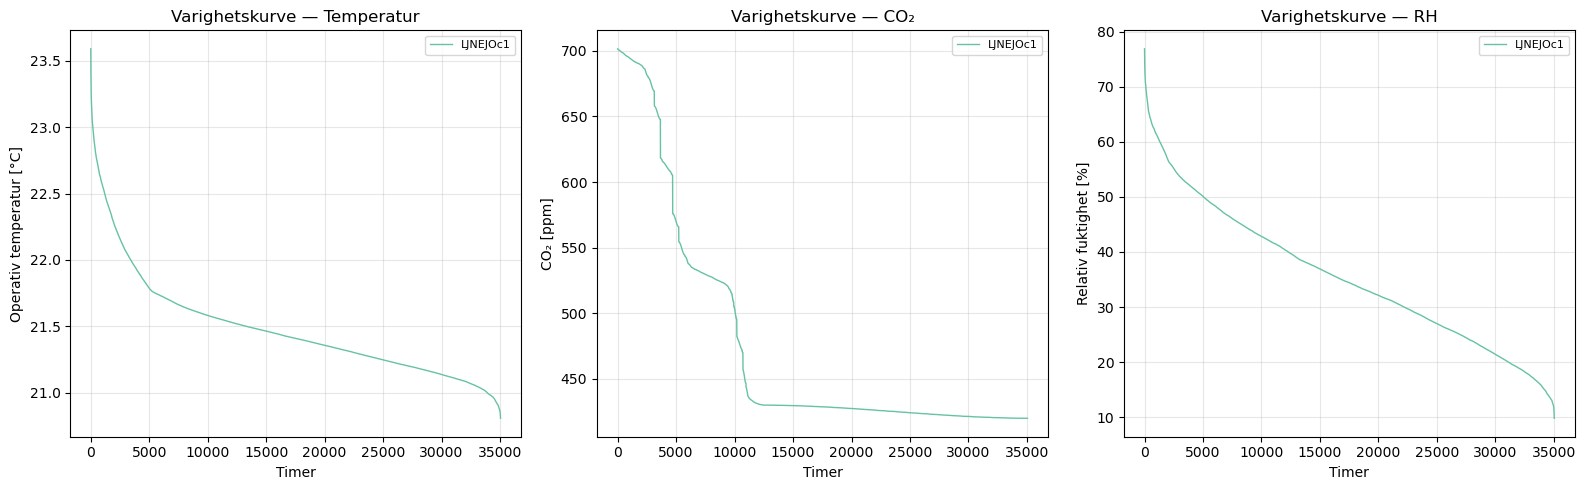

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = plt.cm.Set2(np.linspace(0, 1, len(zone_ids)))

for i, (zone_id, df) in enumerate(inneklima_per_sone.items()):
    label = zone_id[-8:]  # Kort ID
    
    # Temperatur
    sorted_t = np.sort(df['T_operativ'].values)[::-1]
    axes[0].plot(sorted_t, linewidth=1, label=label, color=colors[i])
    axes[0].set_ylabel('Operativ temperatur [°C]')
    axes[0].set_title('Varighetskurve — Temperatur')
    
    # CO2
    sorted_co2 = np.sort(df['CO2'].values)[::-1]
    axes[1].plot(sorted_co2, linewidth=1, label=label, color=colors[i])
    axes[1].set_ylabel('CO₂ [ppm]')
    axes[1].set_title('Varighetskurve — CO₂')
    
    # RH
    sorted_rh = np.sort(df['RH'].values)[::-1]
    axes[2].plot(sorted_rh, linewidth=1, label=label, color=colors[i])
    axes[2].set_ylabel('Relativ fuktighet [%]')
    axes[2].set_title('Varighetskurve — RH')

for ax in axes:
    ax.set_xlabel('Timer')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

## 6. Månedlig statistikk

In [46]:
for zone_id, df in inneklima_per_sone.items():
    monthly = df.resample('M').agg(['mean', 'min', 'max'])
    
    stats = pd.DataFrame({
        'T_op snitt [°C]': monthly[('T_operativ', 'mean')],
        'T_op min [°C]': monthly[('T_operativ', 'min')],
        'T_op maks [°C]': monthly[('T_operativ', 'max')],
        'CO₂ snitt [ppm]': monthly[('CO2', 'mean')],
        'CO₂ maks [ppm]': monthly[('CO2', 'max')],
        'RH snitt [%]': monthly[('RH', 'mean')],
    })
    stats.index = ['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Des']
    
    print(f'\nMånedlig statistikk — {zone_id}')
    print(stats.round(1).to_string())


Månedlig statistikk — soneE6JETHtWgwHndLJNEJOc1
     T_op snitt [°C]  T_op min [°C]  T_op maks [°C]  CO₂ snitt [ppm]  CO₂ maks [ppm]  RH snitt [%]
Jan             21.2           20.9            21.6            473.3           697.3          23.1
Feb             21.1           20.8            21.4            473.2           694.7          24.3
Mar             21.2           20.9            21.5            473.4           692.6          24.4
Apr             21.3           21.0            22.3            472.2           691.8          31.6
Mai             21.6           21.2            23.1            468.9           693.9          35.9
Jun             21.8           21.3            23.3            474.7           695.8          42.3
Jul             22.0           21.5            23.6            475.6           698.4          52.9
Aug             21.9           21.4            23.4            478.1           700.8          51.0
Sep             21.7           21.4            22.9         

## 7. Heatmap — operativ temperatur per time og dag

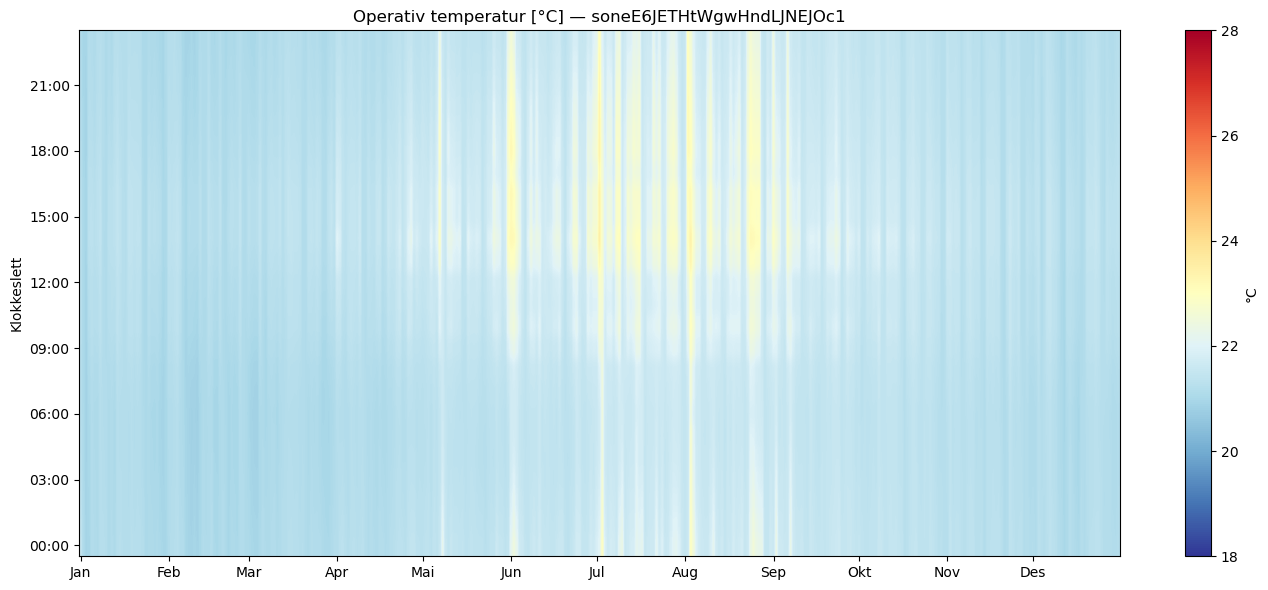

In [47]:
for zone_id, df in inneklima_per_sone.items():
    df_h = df['T_operativ'].resample('h').mean()
    
    # Reshape til 365 dager × 24 timer
    n_full_days = len(df_h) // 24
    matrix = df_h.values[:n_full_days * 24].reshape(n_full_days, 24)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(matrix.T, aspect='auto', cmap='RdYlBu_r', origin='lower',
                   vmin=18, vmax=28)
    
    # Månedsetiketter
    month_starts = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Des']
    ax.set_xticks(month_starts)
    ax.set_xticklabels(month_labels)
    ax.set_yticks(range(0, 24, 3))
    ax.set_yticklabels([f'{h:02d}:00' for h in range(0, 24, 3)])
    
    ax.set_ylabel('Klokkeslett')
    ax.set_title(f'Operativ temperatur [°C] — {zone_id}')
    fig.colorbar(im, ax=ax, label='°C')
    fig.tight_layout()
    plt.show()

## 8. Komfortanalyse

In [ ]:
# Definer grenseverdier
T_MIN, T_MAX = 20.0, 26.0   # °C operativ temperatur
CO2_MAX = 800               # ppm
RH_MIN, RH_MAX = 20.0, 60.0 # %

print('Andel tid innenfor komfortgrenser')
print('=' * 60)

for zone_id, df in inneklima_per_sone.items():
    n = len(df)
    t_ok = ((df['T_operativ'] >= T_MIN) & (df['T_operativ'] <= T_MAX)).sum() / n * 100
    co2_ok = (df['CO2'] <= CO2_MAX).sum() / n * 100
    rh_ok = ((df['RH'] >= RH_MIN) & (df['RH'] <= RH_MAX)).sum() / n * 100
    all_ok = (
        (df['T_operativ'] >= T_MIN) & (df['T_operativ'] <= T_MAX) &
        (df['CO2'] <= CO2_MAX) &
        (df['RH'] >= RH_MIN) & (df['RH'] <= RH_MAX)
    ).sum() / n * 100
    
    print(f'\n{zone_id}')
    print(f'  Temperatur ({T_MIN}–{T_MAX} °C): {t_ok:.1f}%')
    print(f'  CO₂ (≤ {CO2_MAX} ppm):           {co2_ok:.1f}%')
    print(f'  RH ({RH_MIN}–{RH_MAX}%):          {rh_ok:.1f}%')
    print(f'  Alle kriterier oppfylt:     {all_ok:.1f}%')

Andel tid innenfor komfortgrenser

soneE6JETHtWgwHndLJNEJOc1
  Temperatur (20.0–26.0 °C): 100.0%
  CO₂ (≤ 1000 ppm):           100.0%
  RH (20.0–60.0%):          85.1%
  Alle kriterier oppfylt:     85.1%
